<a href="https://colab.research.google.com/github/jansoe/Lehre/blob/main/Perzeptron_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Perceptron
#### imports


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

# adjusting visual output
from matplotlib import rcParams
rcParams['figure.figsize'] = (5, 5)
rcParams['axes.grid'] = False

## Simulation of a dataset to learn and predict

First we simulate a dataset to test our algorithm

* There are 2 classes/categories
  * Every class hat 2 properties

In [40]:
n_datapoint = 30 # number of samples
separation = 1 # how strong are the 2 classes seperated
random_seed = 40

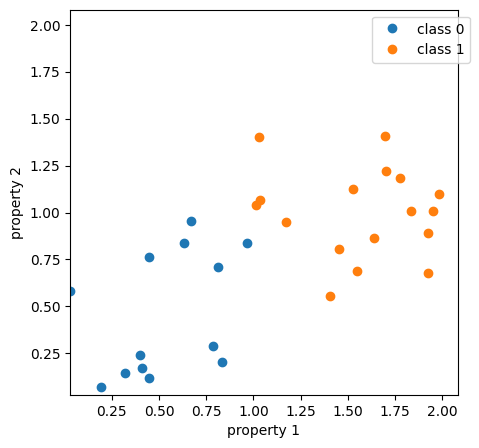

In [41]:
#@markdown hidden code, please execute (code generates a dataset) 

np.random.seed(random_seed)

# generate data
data = np.random.rand(n_datapoint,2)
targets = 1.*(np.random.rand(n_datapoint)<0.5)
data[targets==1, 0] += separation
data[targets==1, 1] += 0.5*separation

# function to plot the data
def plot_data(data, targets, ax):
    
    ax.plot(data[targets==0,0], data[targets==0,1], 'o', label='class 0')
    ax.plot(data[targets==1,0], data[targets==1,1], 'o', label='class 1')

    minval = data.min()
    maxval = data.max()
    lim = [0.95*minval,1.05*maxval]    
    plt.ylim(lim)
    plt.xlim(lim)
    plt.xlabel("property 1")
    plt.ylabel("property 2")
    
    return lim

# plot the data    
fig, ax = plt.subplots(figsize=(5,5))
_ = plot_data(data, targets, ax)
_ = plt.legend(bbox_to_anchor=(1.05, 1))

## Perceptron

### Definition

**Start executing here for a restart of the perceptron learning**

We define a perceptron which assings each 2d-input vector `x` to a class (either 0 or 1) depending on its parameter `w0, w1, theta`.

In [42]:
def perceptron(x, w0, w1, theta):
    activation = x[0]*w0 + x[1]*w1 + theta
    output = int(activation > 0)
    return output

for a randomly choosen parameter set ...

In [58]:
w1 = 1
w0 = 0.5
theta = -1

num_updates =  0

... the perceptron gives us a class:

In [59]:
x = [0.1, 6.5]
perceptron(x, w0, w1, theta)

1

That is, with the perceptron we can classify each point in our property space

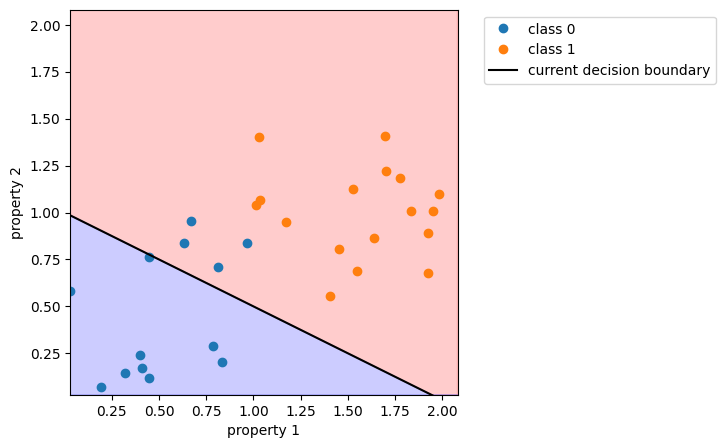

In [60]:
#@title
#@markdown ... Visualisation of the classification ...

import time
import matplotlib
from google.colab import widgets

def plot_boundary(w0, w1, theta, lim, ax, background = True,  **kwargs):
    """ plot the decision boundary paramterized by w and theta within the bounds
        of a square described by lim."""
    
    if (w0==0) and (w1==0):
        x0 = lim
        x1 = [theta, theta] 
    elif w1 == 0:
        # senkrecht
        x0 = [-theta/w0]*2
        x1 = [lim]  
    else:
        x0 = lim
        #x1 = [(x*w0/w1 + theta) for x in x0]
        x1 = [(-x*w0 - theta)/w1 for x in x0]
    
    ax.plot(x0, x1, 'k', **kwargs)
    plt.xlim(lim)
    
    class_00=perceptron((x0[0], x0[0]), w0, w1, theta),
    if background:
        mi, ma = x0 
        b_x0, b_x1 = x1
        #color1 = 'b' if w0 < w1 else 'r'
        #color2 = 'r' if color1 == 'b' else 'b'
        color1 = 'b' if (class_00 and (b_x0 <0)) else 'r'
        color2 = 'r' if color1 == 'b' else 'b'
        area_0 = matplotlib.patches.Polygon(
            [(mi, b_x0), (ma, b_x1), (ma, ma), (mi, ma), (mi, b_x0)],
            #[(x0[0], x1[0]), (x0[1], x1[1]), 
            #(x0[1], x0[0]), (x0[0], x0[0]), 
            #(x0[0], x1[1]), (x0[0], x0[1]),
            #],
            alpha=0.2, color=color1
        )
        area_1 = matplotlib.patches.Polygon(
            [(mi, b_x0), (ma, b_x1), (ma, mi), (mi, mi), (mi, b_x0)],
            #[(x0[1], x0[1]), (x0[0], x0[1]), (x0[0], x1[0]), 
            #(x0[1], x1[1]), (x0[1], x0[0]), (x0[1], x1[0])],
            alpha=0.2, color=color2
        )
        plt.gca().add_patch(area_0)
        plt.gca().add_patch(area_1)


class TrennebenenPlotter():

    def __init__(self, data, targets, w0, w1, theta):

        self.data = data
        self.targets = targets
        self.w0_old = w0
        self.w1_old = w1
        self.theta_old = theta


    def plot_update(self, datenpunkt, w0, w1, theta, old=True):
        
        fig, ax = plt.subplots(figsize=(5,5))
        lim = plot_data(self.data, self.targets, ax)
        plot_boundary(w0, w1, theta, lim, ax, label='decision boundary after update')

        if old:
            plot_boundary(
                self.w0_old, self.w1_old, self.theta_old, lim, ax, 
                background = False, alpha=0.2, label='decision boundary before'
            )
            ax.plot(datenpunkt[0], datenpunkt[1], 'or', markersize = 10, mfc='none')
            _ = plt.legend(bbox_to_anchor=(1.05, 1))

        # we save the old values to visualize later
        self.w0_old = w0
        self.w1_old = w1
        self.theta_old = theta


vis = TrennebenenPlotter(data, targets, w0, w1, theta)
fig, ax = plt.subplots(figsize = (5,5))
lim = plot_data(data, targets, ax)
_ = plot_boundary(w0,  w1, theta, lim, ax, 
    label="current decision boundary")
_ = plt.legend(bbox_to_anchor=(1.05, 1))


### Learning

In [53]:
steps = 210 # Learning steps: how many datapoints are updated   
learnrate = 0.1 # How strong is an update

wait_time = 1 # Time between plotting the next update (to be able to better follow)

The following implements the learning rule. Once a wrongly classified datapoint is found, an update is performed and visualized 

In [54]:
num_updates

150

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

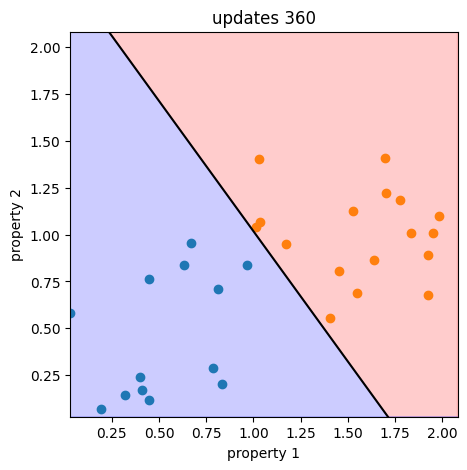

In [55]:
grid = widgets.Grid(1, 1, header_row=False, header_column=False)
for i in range(steps):

    # choose the next datapoint
    data_point = data[num_updates%len(data)]
    target_output = targets[num_updates%len(data)]

    # calculate the output
    perceptron_output = perceptron(data_point, w0, w1, theta)

    # and compare with the target output
    error = target_output - perceptron_output 

    if error != 0:
        # decrease/increase output if output was to big/small
        # change is proportional to influence of the dimension to the output value
        w0 = w0 + learnrate * error * data_point[0]
        w1 = w1 + learnrate * error * data_point[1]   
        theta = theta + learnrate * error

        # only visualitation
        with grid.output_to(0, 0):
            grid.clear_cell()
            vis.plot_update(data_point, w0, w1, theta)
            plt.title('updates '+str(num_updates))
            plt.show()
        if steps > 1:
            time.sleep(wait_time)

    num_updates += 1


with grid.output_to(0, 0):
    grid.clear_cell()
    vis.plot_update(data_point, w0, w1, theta, old=False)
    plt.title('updates '+str(num_updates))

In [57]:
print(w0, w1, theta)

0.750193395025942 0.5403325957626798 -1.3000000000000003


## Tasks: experiments

1. Choose different learning rates. What do you observe? (Remark: If you rerun the training cell, learning will continue.) 

2. Randomly choose the inital parameters (`w0`, `w1`, `theta`) of the perceptron. What do you observe?

3. Change the parameter `separation` such that the classes in the dataset are closer together. Again try different learning rates. What do you observe?

4. Rewrite the perceptron, that it takes as input for the data and the weights a numpy array of arbitrary dimension
```
def perceptron(x_array, w_array, theta):
    ...
``` 